In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [3]:
from src.lib.fact_dataset_generator import FactDatasetGenerator
import numpy as np
import sys
import pandas as pd
import torch
import json

# Embeddings Experiment

## 1. Visualize hallucinations in training data space

## 2. Check if hallucinations are close to monofacts (closest training point)

## 3. Find Areas in the training data space with clustering

## 4. Check if hallucination rate is higher in the clusters with lots of monofacts

# Loading training data embeddings

In [4]:
loaded_monofact_embeddings = []
loaded_normal_fact_embeddings = []


with open("../src/experiment/monofact_embeddings.json","r") as f:
    for line in f:
        loaded_monofact_embeddings.append(json.loads(line))
with open("../src/experiment/normal_fact_embeddings.json","r") as f:
    for line in f:
        loaded_normal_fact_embeddings.append(json.loads(line))


In [5]:
monofact_embeddings = []
normal_fact_embeddings = []
all_training_embeddings = []
embedding_of = []
embedding_of_training = []

for loaded_normal_fact, loaded_normal_fact_embedding in loaded_normal_fact_embeddings:
    normal_fact_embeddings.append((loaded_normal_fact, torch.tensor(loaded_normal_fact_embedding)))
    all_training_embeddings.append(torch.tensor(loaded_normal_fact_embedding))
    embedding_of.append('Popular fact')
    embedding_of_training.append('Popular fact')
for loaded_monofact, loaded_monofact_embedding in loaded_monofact_embeddings:
    monofact_embeddings.append((loaded_monofact, torch.tensor(loaded_monofact_embedding)))
    all_training_embeddings.append(torch.tensor(loaded_monofact_embedding))
    embedding_of.append('Monofact')
    embedding_of_training.append('Monofact')

In [6]:
all_training_embeddings_numpy = torch.cat([a.unsqueeze(0) for a in all_training_embeddings]).detach().numpy()

In [7]:
torch.cuda.empty_cache()

In [8]:
all_training_embeddings_numpy.shape

(800, 1536)

# Load embeddings of generations

In [9]:
generated_hallucinations_embeddings = []
with open("../src/experiment/hallucination_embeddings.json","r") as f:
    for line in f:
        generated_hallucinations_embeddings.append(json.loads(line))

generated_facts_embeddings = []
with open("../src/experiment/generated_fact_embeddings.json","r") as f:
    for line in f:
        generation = json.loads(line)
        is_hallucination = False

        # Filter out hallucinations
        for (hallucination, _) in generated_hallucinations_embeddings:
            if str(generation[0]) == str(hallucination):
                is_hallucination = True
                break

        if is_hallucination is False:
            generated_facts_embeddings.append(generation)

In [10]:
len(generated_facts_embeddings), len(generated_hallucinations_embeddings)

(945, 55)

# 1. Visualize training and hallucinations space

### add hallucinations to embeddings to visualize

In [11]:
hallucinations_embeddings_numpy = torch.cat([torch.Tensor(a[1]).unsqueeze(0) for a in generated_hallucinations_embeddings]).detach().numpy()

In [12]:
generated_facts_embeddings_numpy = torch.cat([torch.Tensor(a[1]).unsqueeze(0) for a in generated_facts_embeddings]).detach().numpy()

In [13]:
hallucinations_embeddings_numpy.shape

(55, 1536)

In [14]:
numpy_to_plot = np.concatenate([all_training_embeddings_numpy, hallucinations_embeddings_numpy])

import numpy as np
from sklearn.manifold import TSNE
# fit tsne on training samples
tsne = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3)

X_embedded = tsne.fit_transform(numpy_to_plot)

In [15]:
embedding_of += (['Hallucination'] * len(generated_hallucinations_embeddings))

In [16]:
import matplotlib.pyplot as plt

In [17]:
colors = {
    'Hallucination': 'red',
    'Popular fact': 'lightblue',
    'Monofact': 'purple'
}

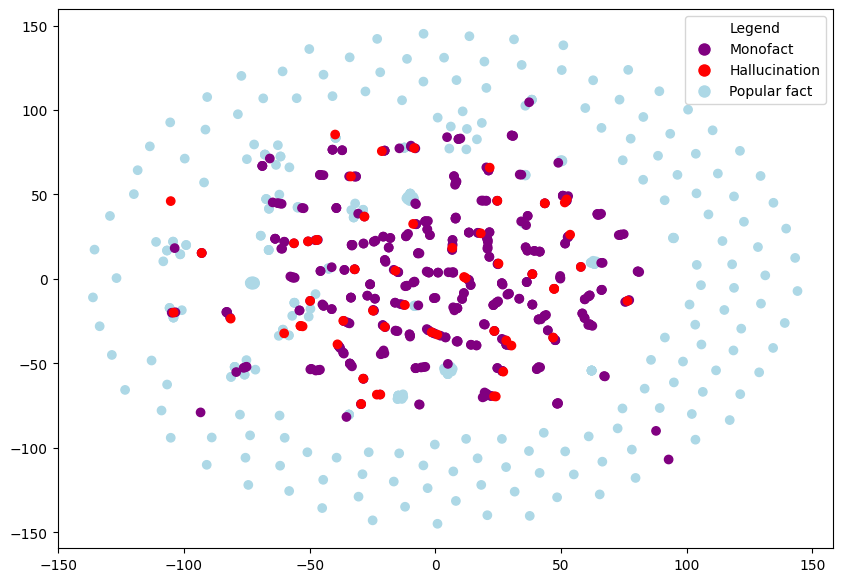

In [18]:
unique_labels = set(embedding_of)
label_color_map = {label: colors[label] for label in unique_labels}

# Create scatter plot
plt.figure(figsize=(10, 7))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=[colors[c] for c in embedding_of])

# Create a list of handles (proxy artists) for the legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for label, color in label_color_map.items()]
labels = list(label_color_map.keys())

# Add legend to the plot
plt.legend(handles, labels, title="Legend")

# Show the plot
# plt.savefig('../assets/hallucination_in_space.png', dpi=500)
plt.show()

# 2. Check to which points hallucinations vs true generations are closest

In [19]:
from numpy import dot
import numpy as np
from numpy.linalg import norm

def dist(tensor_a, tensor_b):
    a = tensor_a.detach().numpy()
    b = tensor_b.detach().numpy()
    # return dot(a, b)/(norm(a)*norm(b))
    return np.linalg.norm(a-b)

In [20]:
def closest_different_point(embedding, top_k = 3):
    smallest_dist = 1E9
    result = None

    distances = []
    
    for loaded_monofact, loaded_monofact_embedding in loaded_monofact_embeddings:
        mf_embedding = torch.tensor(loaded_monofact_embedding)

        d = dist(embedding, mf_embedding)
        distances.append({'dist': d, 'type': 'Monofact'})

    for loaded_normal_fact, loaded_normal_fact_embedding in loaded_normal_fact_embeddings:
        nf_embedding = torch.tensor(loaded_normal_fact_embedding)

        d = dist(embedding, nf_embedding)
        distances.append({'dist': d, 'type': 'Popular Fact'})

    return pd.DataFrame(distances).sort_values(by='dist').reset_index(drop=True)['type'].head(top_k).value_counts()

In [21]:
from tqdm import tqdm

In [36]:
result = []

for embedding in tqdm(generated_facts_embeddings):
    embedding = torch.Tensor(embedding[1])
    closest = dict(closest_different_point(embedding, top_k=1))

    closest_point = {'Monofact': 0, 'Hallucination': 0, 'Popular fact': 0}
    closest_point.update(**closest)

    closest_point['Point'] = 'Generated True Fact'

    print('Generated True Fact', closest)

    result.append(closest_point)

  0%|▎                                                                                                                         | 2/945 [00:00<02:38,  5.94it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


  0%|▌                                                                                                                         | 4/945 [00:00<02:28,  6.33it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


  1%|▊                                                                                                                         | 6/945 [00:01<02:48,  5.59it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


  1%|█                                                                                                                         | 8/945 [00:01<02:37,  5.95it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


  1%|█▎                                                                                                                       | 10/945 [00:01<02:35,  6.00it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


  1%|█▌                                                                                                                       | 12/945 [00:01<02:30,  6.18it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


  1%|█▊                                                                                                                       | 14/945 [00:02<02:33,  6.08it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


  2%|█▉                                                                                                                       | 15/945 [00:02<02:31,  6.13it/s]

Generated True Fact {'Popular Fact': 1}


  2%|██▏                                                                                                                      | 17/945 [00:03<03:12,  4.83it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


  2%|██▎                                                                                                                      | 18/945 [00:03<03:41,  4.19it/s]

Generated True Fact {'Popular Fact': 1}


  2%|██▍                                                                                                                      | 19/945 [00:03<03:49,  4.04it/s]

Generated True Fact {'Monofact': 1}


  2%|██▌                                                                                                                      | 20/945 [00:03<04:10,  3.70it/s]

Generated True Fact {'Popular Fact': 1}


  2%|██▊                                                                                                                      | 22/945 [00:04<03:39,  4.21it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


  3%|███                                                                                                                      | 24/945 [00:04<03:04,  4.99it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


  3%|███▎                                                                                                                     | 26/945 [00:04<02:43,  5.61it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


  3%|███▌                                                                                                                     | 28/945 [00:05<02:42,  5.64it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


  3%|███▊                                                                                                                     | 30/945 [00:05<02:31,  6.05it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


  3%|████                                                                                                                     | 32/945 [00:05<02:30,  6.06it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


  4%|████▎                                                                                                                    | 34/945 [00:06<02:32,  5.97it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


  4%|████▌                                                                                                                    | 36/945 [00:06<02:28,  6.14it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


  4%|████▊                                                                                                                    | 38/945 [00:06<02:22,  6.36it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


  4%|█████                                                                                                                    | 40/945 [00:07<02:19,  6.49it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


  4%|█████▍                                                                                                                   | 42/945 [00:07<02:17,  6.55it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


  5%|█████▋                                                                                                                   | 44/945 [00:07<02:16,  6.59it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


  5%|█████▉                                                                                                                   | 46/945 [00:08<02:16,  6.61it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


  5%|██████▏                                                                                                                  | 48/945 [00:08<02:15,  6.62it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


  5%|██████▍                                                                                                                  | 50/945 [00:08<02:15,  6.62it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


  6%|██████▋                                                                                                                  | 52/945 [00:09<02:14,  6.62it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


  6%|██████▉                                                                                                                  | 54/945 [00:09<02:14,  6.62it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


  6%|███████▏                                                                                                                 | 56/945 [00:09<02:16,  6.52it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


  6%|███████▍                                                                                                                 | 58/945 [00:09<02:15,  6.53it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


  6%|███████▋                                                                                                                 | 60/945 [00:10<02:20,  6.29it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


  7%|███████▉                                                                                                                 | 62/945 [00:10<02:17,  6.43it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


  7%|████████▏                                                                                                                | 64/945 [00:10<02:15,  6.51it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


  7%|████████▍                                                                                                                | 66/945 [00:11<02:14,  6.54it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


  7%|████████▋                                                                                                                | 68/945 [00:11<02:13,  6.55it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


  7%|████████▉                                                                                                                | 70/945 [00:11<02:13,  6.56it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


  8%|█████████▏                                                                                                               | 72/945 [00:12<02:13,  6.54it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


  8%|█████████▍                                                                                                               | 74/945 [00:12<02:12,  6.56it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


  8%|█████████▋                                                                                                               | 76/945 [00:12<02:12,  6.54it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


  8%|█████████▉                                                                                                               | 78/945 [00:13<02:12,  6.55it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


  8%|██████████▏                                                                                                              | 80/945 [00:13<02:12,  6.53it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


  9%|██████████▍                                                                                                              | 82/945 [00:13<02:12,  6.50it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


  9%|██████████▊                                                                                                              | 84/945 [00:13<02:12,  6.50it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


  9%|███████████                                                                                                              | 86/945 [00:14<02:11,  6.54it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


  9%|███████████▎                                                                                                             | 88/945 [00:14<02:11,  6.52it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 10%|███████████▌                                                                                                             | 90/945 [00:14<02:21,  6.04it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 10%|███████████▊                                                                                                             | 92/945 [00:15<02:15,  6.31it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 10%|████████████                                                                                                             | 94/945 [00:15<02:12,  6.43it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 10%|████████████▎                                                                                                            | 96/945 [00:15<02:10,  6.48it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 10%|████████████▌                                                                                                            | 98/945 [00:16<02:09,  6.53it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 11%|████████████▋                                                                                                           | 100/945 [00:16<02:08,  6.56it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 11%|████████████▉                                                                                                           | 102/945 [00:16<02:08,  6.56it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 11%|█████████████▏                                                                                                          | 104/945 [00:17<02:07,  6.58it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 11%|█████████████▍                                                                                                          | 106/945 [00:17<02:07,  6.59it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 11%|█████████████▋                                                                                                          | 108/945 [00:17<02:06,  6.59it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 12%|█████████████▉                                                                                                          | 110/945 [00:17<02:07,  6.56it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 12%|██████████████▏                                                                                                         | 112/945 [00:18<02:07,  6.55it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 12%|██████████████▍                                                                                                         | 114/945 [00:18<02:07,  6.52it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 12%|██████████████▋                                                                                                         | 116/945 [00:18<02:06,  6.54it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 12%|██████████████▉                                                                                                         | 118/945 [00:19<02:06,  6.53it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 13%|███████████████▏                                                                                                        | 120/945 [00:19<02:06,  6.53it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 13%|███████████████▍                                                                                                        | 122/945 [00:19<02:06,  6.53it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 13%|███████████████▋                                                                                                        | 124/945 [00:20<02:05,  6.52it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 13%|████████████████                                                                                                        | 126/945 [00:20<02:05,  6.54it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 14%|████████████████▎                                                                                                       | 128/945 [00:20<02:05,  6.52it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 14%|████████████████▌                                                                                                       | 130/945 [00:21<02:06,  6.44it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 14%|████████████████▊                                                                                                       | 132/945 [00:21<02:05,  6.50it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 14%|█████████████████                                                                                                       | 134/945 [00:21<02:04,  6.53it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 14%|█████████████████▎                                                                                                      | 136/945 [00:21<02:04,  6.51it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 15%|█████████████████▌                                                                                                      | 138/945 [00:22<02:05,  6.44it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 15%|█████████████████▊                                                                                                      | 140/945 [00:22<02:05,  6.42it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 15%|██████████████████                                                                                                      | 142/945 [00:22<02:05,  6.37it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 15%|██████████████████▎                                                                                                     | 144/945 [00:23<02:04,  6.45it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 15%|██████████████████▌                                                                                                     | 146/945 [00:23<02:14,  5.95it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 16%|██████████████████▊                                                                                                     | 148/945 [00:23<02:09,  6.15it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 16%|███████████████████                                                                                                     | 150/945 [00:24<02:05,  6.36it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 16%|███████████████████▎                                                                                                    | 152/945 [00:24<02:02,  6.45it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 16%|███████████████████▌                                                                                                    | 154/945 [00:24<02:01,  6.51it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 17%|███████████████████▊                                                                                                    | 156/945 [00:25<02:01,  6.48it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 17%|████████████████████                                                                                                    | 158/945 [00:25<02:01,  6.45it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 17%|████████████████████▎                                                                                                   | 160/945 [00:25<02:00,  6.53it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 17%|████████████████████▌                                                                                                   | 162/945 [00:26<02:01,  6.46it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 17%|████████████████████▊                                                                                                   | 164/945 [00:26<02:01,  6.45it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 18%|█████████████████████                                                                                                   | 166/945 [00:26<02:00,  6.44it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 18%|█████████████████████▎                                                                                                  | 168/945 [00:27<02:00,  6.44it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 18%|█████████████████████▌                                                                                                  | 170/945 [00:27<02:00,  6.42it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 18%|█████████████████████▊                                                                                                  | 172/945 [00:27<01:58,  6.50it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 18%|██████████████████████                                                                                                  | 174/945 [00:27<01:57,  6.56it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 19%|██████████████████████▎                                                                                                 | 176/945 [00:28<01:56,  6.58it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 19%|██████████████████████▌                                                                                                 | 178/945 [00:28<01:59,  6.44it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 19%|██████████████████████▊                                                                                                 | 180/945 [00:28<01:57,  6.51it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 19%|███████████████████████                                                                                                 | 182/945 [00:29<01:57,  6.50it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 19%|███████████████████████▎                                                                                                | 184/945 [00:29<01:56,  6.54it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 20%|███████████████████████▌                                                                                                | 186/945 [00:29<01:56,  6.53it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 20%|███████████████████████▊                                                                                                | 188/945 [00:30<01:56,  6.49it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 20%|████████████████████████▏                                                                                               | 190/945 [00:30<01:56,  6.50it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 20%|████████████████████████▍                                                                                               | 192/945 [00:30<01:55,  6.52it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 21%|████████████████████████▋                                                                                               | 194/945 [00:30<01:54,  6.56it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 21%|████████████████████████▉                                                                                               | 196/945 [00:31<01:53,  6.57it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 21%|█████████████████████████▏                                                                                              | 198/945 [00:31<02:00,  6.20it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 21%|█████████████████████████▍                                                                                              | 200/945 [00:31<01:56,  6.38it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 21%|█████████████████████████▋                                                                                              | 202/945 [00:32<02:02,  6.05it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 22%|█████████████████████████▉                                                                                              | 204/945 [00:32<01:57,  6.31it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 22%|██████████████████████████▏                                                                                             | 206/945 [00:32<01:54,  6.46it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 22%|██████████████████████████▍                                                                                             | 208/945 [00:33<01:52,  6.53it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 22%|██████████████████████████▋                                                                                             | 210/945 [00:33<01:51,  6.57it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 22%|██████████████████████████▉                                                                                             | 212/945 [00:33<01:51,  6.57it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 23%|███████████████████████████▏                                                                                            | 214/945 [00:34<01:51,  6.56it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 23%|███████████████████████████▍                                                                                            | 216/945 [00:34<01:50,  6.57it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 23%|███████████████████████████▋                                                                                            | 218/945 [00:34<01:50,  6.59it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 23%|███████████████████████████▉                                                                                            | 220/945 [00:35<01:49,  6.59it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 23%|████████████████████████████▏                                                                                           | 222/945 [00:35<01:49,  6.59it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 24%|████████████████████████████▍                                                                                           | 224/945 [00:35<01:50,  6.53it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 24%|████████████████████████████▋                                                                                           | 226/945 [00:35<01:49,  6.55it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 24%|████████████████████████████▉                                                                                           | 228/945 [00:36<01:48,  6.59it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 24%|█████████████████████████████▏                                                                                          | 230/945 [00:36<01:48,  6.59it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 25%|█████████████████████████████▍                                                                                          | 232/945 [00:36<01:48,  6.60it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 25%|█████████████████████████████▋                                                                                          | 234/945 [00:37<01:47,  6.60it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 25%|█████████████████████████████▉                                                                                          | 236/945 [00:37<01:47,  6.58it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 25%|██████████████████████████████▏                                                                                         | 238/945 [00:37<01:48,  6.52it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 25%|██████████████████████████████▍                                                                                         | 240/945 [00:38<01:47,  6.57it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 26%|██████████████████████████████▋                                                                                         | 242/945 [00:38<01:46,  6.59it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 26%|██████████████████████████████▉                                                                                         | 244/945 [00:38<01:46,  6.60it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 26%|███████████████████████████████▏                                                                                        | 246/945 [00:38<01:45,  6.61it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 26%|███████████████████████████████▍                                                                                        | 248/945 [00:39<01:45,  6.60it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 26%|███████████████████████████████▋                                                                                        | 250/945 [00:39<01:45,  6.60it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 27%|████████████████████████████████                                                                                        | 252/945 [00:39<01:45,  6.59it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 27%|████████████████████████████████▎                                                                                       | 254/945 [00:40<01:44,  6.58it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 27%|████████████████████████████████▌                                                                                       | 256/945 [00:40<01:44,  6.58it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 27%|████████████████████████████████▊                                                                                       | 258/945 [00:40<01:44,  6.59it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 28%|█████████████████████████████████                                                                                       | 260/945 [00:41<01:48,  6.30it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 28%|█████████████████████████████████▎                                                                                      | 262/945 [00:41<01:45,  6.46it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 28%|█████████████████████████████████▌                                                                                      | 264/945 [00:41<01:48,  6.29it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 28%|█████████████████████████████████▊                                                                                      | 266/945 [00:42<01:45,  6.45it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 28%|██████████████████████████████████                                                                                      | 268/945 [00:42<01:44,  6.48it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 29%|██████████████████████████████████▎                                                                                     | 270/945 [00:42<01:43,  6.52it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 29%|██████████████████████████████████▌                                                                                     | 272/945 [00:42<01:42,  6.54it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 29%|██████████████████████████████████▊                                                                                     | 274/945 [00:43<01:44,  6.43it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 29%|███████████████████████████████████                                                                                     | 276/945 [00:43<01:43,  6.49it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 29%|███████████████████████████████████▎                                                                                    | 278/945 [00:43<01:43,  6.44it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 30%|███████████████████████████████████▌                                                                                    | 280/945 [00:44<01:42,  6.49it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 30%|███████████████████████████████████▊                                                                                    | 282/945 [00:44<01:45,  6.26it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 30%|████████████████████████████████████                                                                                    | 284/945 [00:44<01:42,  6.43it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 30%|████████████████████████████████████▎                                                                                   | 286/945 [00:45<01:41,  6.52it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 30%|████████████████████████████████████▌                                                                                   | 288/945 [00:45<01:40,  6.52it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 31%|████████████████████████████████████▊                                                                                   | 290/945 [00:45<01:40,  6.54it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 31%|█████████████████████████████████████                                                                                   | 292/945 [00:46<01:39,  6.57it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 31%|█████████████████████████████████████▎                                                                                  | 294/945 [00:46<01:39,  6.55it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 31%|█████████████████████████████████████▌                                                                                  | 296/945 [00:46<01:38,  6.56it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 32%|█████████████████████████████████████▊                                                                                  | 298/945 [00:46<01:38,  6.58it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 32%|██████████████████████████████████████                                                                                  | 300/945 [00:47<01:37,  6.59it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 32%|██████████████████████████████████████▎                                                                                 | 302/945 [00:47<01:37,  6.59it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 32%|██████████████████████████████████████▌                                                                                 | 304/945 [00:47<01:37,  6.59it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 32%|██████████████████████████████████████▊                                                                                 | 306/945 [00:48<01:38,  6.51it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 33%|███████████████████████████████████████                                                                                 | 308/945 [00:48<01:37,  6.53it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 33%|███████████████████████████████████████▎                                                                                | 310/945 [00:48<01:41,  6.24it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 33%|███████████████████████████████████████▌                                                                                | 312/945 [00:49<01:38,  6.43it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 33%|███████████████████████████████████████▊                                                                                | 314/945 [00:49<01:36,  6.53it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 33%|████████████████████████████████████████▏                                                                               | 316/945 [00:49<01:35,  6.58it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 34%|████████████████████████████████████████▍                                                                               | 318/945 [00:50<01:39,  6.30it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 34%|████████████████████████████████████████▋                                                                               | 320/945 [00:50<01:36,  6.46it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 34%|████████████████████████████████████████▉                                                                               | 322/945 [00:50<01:39,  6.26it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 34%|█████████████████████████████████████████▏                                                                              | 324/945 [00:51<01:37,  6.39it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 34%|█████████████████████████████████████████▍                                                                              | 326/945 [00:51<01:35,  6.48it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 35%|█████████████████████████████████████████▋                                                                              | 328/945 [00:51<01:34,  6.51it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 35%|█████████████████████████████████████████▉                                                                              | 330/945 [00:51<01:34,  6.51it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 35%|██████████████████████████████████████████▏                                                                             | 332/945 [00:52<01:33,  6.53it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 35%|██████████████████████████████████████████▍                                                                             | 334/945 [00:52<01:36,  6.31it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 36%|██████████████████████████████████████████▋                                                                             | 336/945 [00:52<01:36,  6.30it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 36%|██████████████████████████████████████████▉                                                                             | 338/945 [00:53<01:35,  6.34it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 36%|███████████████████████████████████████████▏                                                                            | 340/945 [00:53<01:33,  6.46it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 36%|███████████████████████████████████████████▍                                                                            | 342/945 [00:53<01:33,  6.42it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 36%|███████████████████████████████████████████▋                                                                            | 344/945 [00:54<01:32,  6.51it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 37%|███████████████████████████████████████████▉                                                                            | 346/945 [00:54<01:31,  6.52it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 37%|████████████████████████████████████████████▏                                                                           | 348/945 [00:54<01:31,  6.50it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 37%|████████████████████████████████████████████▍                                                                           | 350/945 [00:55<01:31,  6.53it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 37%|████████████████████████████████████████████▋                                                                           | 352/945 [00:55<01:30,  6.52it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 37%|████████████████████████████████████████████▉                                                                           | 354/945 [00:55<01:30,  6.56it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 38%|█████████████████████████████████████████████▏                                                                          | 356/945 [00:55<01:29,  6.58it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 38%|█████████████████████████████████████████████▍                                                                          | 358/945 [00:56<01:29,  6.55it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 38%|█████████████████████████████████████████████▋                                                                          | 360/945 [00:56<01:29,  6.54it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 38%|█████████████████████████████████████████████▉                                                                          | 362/945 [00:56<01:30,  6.45it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 39%|██████████████████████████████████████████████▏                                                                         | 364/945 [00:57<01:30,  6.42it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 39%|██████████████████████████████████████████████▍                                                                         | 366/945 [00:57<01:29,  6.45it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 39%|██████████████████████████████████████████████▋                                                                         | 368/945 [00:57<01:28,  6.49it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 39%|██████████████████████████████████████████████▉                                                                         | 370/945 [00:58<01:29,  6.43it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 39%|███████████████████████████████████████████████▏                                                                        | 372/945 [00:58<01:28,  6.45it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 39%|███████████████████████████████████████████████▎                                                                        | 373/945 [00:58<01:29,  6.37it/s]

Generated True Fact {'Popular Fact': 1}


 40%|███████████████████████████████████████████████▌                                                                        | 375/945 [00:58<01:34,  6.04it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 40%|███████████████████████████████████████████████▊                                                                        | 377/945 [00:59<01:30,  6.26it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 40%|████████████████████████████████████████████████▏                                                                       | 379/945 [00:59<01:29,  6.31it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 40%|████████████████████████████████████████████████▍                                                                       | 381/945 [00:59<01:27,  6.47it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 41%|████████████████████████████████████████████████▋                                                                       | 383/945 [01:00<01:25,  6.54it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 41%|████████████████████████████████████████████████▉                                                                       | 385/945 [01:00<01:25,  6.59it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 41%|█████████████████████████████████████████████████▏                                                                      | 387/945 [01:00<01:25,  6.50it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 41%|█████████████████████████████████████████████████▍                                                                      | 389/945 [01:01<01:27,  6.35it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 41%|█████████████████████████████████████████████████▋                                                                      | 391/945 [01:01<01:25,  6.49it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 42%|█████████████████████████████████████████████████▉                                                                      | 393/945 [01:01<01:24,  6.54it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 42%|██████████████████████████████████████████████████▏                                                                     | 395/945 [01:02<01:23,  6.55it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 42%|██████████████████████████████████████████████████▍                                                                     | 397/945 [01:02<01:23,  6.56it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 42%|██████████████████████████████████████████████████▋                                                                     | 399/945 [01:02<01:22,  6.59it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 42%|██████████████████████████████████████████████████▉                                                                     | 401/945 [01:02<01:22,  6.58it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 43%|███████████████████████████████████████████████████▏                                                                    | 403/945 [01:03<01:22,  6.59it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 43%|███████████████████████████████████████████████████▍                                                                    | 405/945 [01:03<01:22,  6.58it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 43%|███████████████████████████████████████████████████▋                                                                    | 407/945 [01:03<01:21,  6.57it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 43%|███████████████████████████████████████████████████▉                                                                    | 409/945 [01:04<01:21,  6.59it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 43%|████████████████████████████████████████████████████▏                                                                   | 411/945 [01:04<01:20,  6.60it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 44%|████████████████████████████████████████████████████▍                                                                   | 413/945 [01:04<01:20,  6.60it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 44%|████████████████████████████████████████████████████▋                                                                   | 415/945 [01:05<01:20,  6.58it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 44%|████████████████████████████████████████████████████▉                                                                   | 417/945 [01:05<01:20,  6.57it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 44%|█████████████████████████████████████████████████████▏                                                                  | 419/945 [01:05<01:19,  6.58it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 45%|█████████████████████████████████████████████████████▍                                                                  | 421/945 [01:06<01:19,  6.58it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 45%|█████████████████████████████████████████████████████▋                                                                  | 423/945 [01:06<01:19,  6.59it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 45%|█████████████████████████████████████████████████████▉                                                                  | 425/945 [01:06<01:18,  6.60it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 45%|██████████████████████████████████████████████████████▏                                                                 | 427/945 [01:06<01:18,  6.58it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 45%|██████████████████████████████████████████████████████▍                                                                 | 429/945 [01:07<01:18,  6.60it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 46%|██████████████████████████████████████████████████████▋                                                                 | 431/945 [01:07<01:22,  6.20it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 46%|██████████████████████████████████████████████████████▉                                                                 | 433/945 [01:07<01:20,  6.38it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 46%|███████████████████████████████████████████████████████▏                                                                | 435/945 [01:08<01:18,  6.49it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 46%|███████████████████████████████████████████████████████▍                                                                | 437/945 [01:08<01:17,  6.55it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 46%|███████████████████████████████████████████████████████▋                                                                | 439/945 [01:08<01:17,  6.54it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 47%|████████████████████████████████████████████████████████                                                                | 441/945 [01:09<01:16,  6.56it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 47%|████████████████████████████████████████████████████████▎                                                               | 443/945 [01:09<01:16,  6.58it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 47%|████████████████████████████████████████████████████████▌                                                               | 445/945 [01:09<01:15,  6.59it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 47%|████████████████████████████████████████████████████████▊                                                               | 447/945 [01:10<01:15,  6.57it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 48%|█████████████████████████████████████████████████████████                                                               | 449/945 [01:10<01:15,  6.57it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 48%|█████████████████████████████████████████████████████████▎                                                              | 451/945 [01:10<01:15,  6.59it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 48%|█████████████████████████████████████████████████████████▌                                                              | 453/945 [01:10<01:14,  6.57it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 48%|█████████████████████████████████████████████████████████▊                                                              | 455/945 [01:11<01:14,  6.56it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 48%|██████████████████████████████████████████████████████████                                                              | 457/945 [01:11<01:14,  6.57it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 49%|██████████████████████████████████████████████████████████▎                                                             | 459/945 [01:11<01:14,  6.56it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 49%|██████████████████████████████████████████████████████████▌                                                             | 461/945 [01:12<01:13,  6.57it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 49%|██████████████████████████████████████████████████████████▊                                                             | 463/945 [01:12<01:13,  6.57it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 49%|███████████████████████████████████████████████████████████                                                             | 465/945 [01:12<01:13,  6.53it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 49%|███████████████████████████████████████████████████████████▎                                                            | 467/945 [01:13<01:12,  6.55it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 50%|███████████████████████████████████████████████████████████▌                                                            | 469/945 [01:13<01:12,  6.57it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 50%|███████████████████████████████████████████████████████████▊                                                            | 471/945 [01:13<01:12,  6.53it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 50%|████████████████████████████████████████████████████████████                                                            | 473/945 [01:13<01:12,  6.55it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 50%|████████████████████████████████████████████████████████████▎                                                           | 475/945 [01:14<01:11,  6.58it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 50%|████████████████████████████████████████████████████████████▌                                                           | 477/945 [01:14<01:11,  6.53it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 51%|████████████████████████████████████████████████████████████▊                                                           | 479/945 [01:14<01:11,  6.51it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 51%|█████████████████████████████████████████████████████████████                                                           | 481/945 [01:15<01:11,  6.53it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 51%|█████████████████████████████████████████████████████████████▎                                                          | 483/945 [01:15<01:10,  6.52it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 51%|█████████████████████████████████████████████████████████████▌                                                          | 485/945 [01:15<01:10,  6.51it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 52%|█████████████████████████████████████████████████████████████▊                                                          | 487/945 [01:16<01:10,  6.51it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 52%|██████████████████████████████████████████████████████████████                                                          | 489/945 [01:16<01:15,  6.03it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 52%|██████████████████████████████████████████████████████████████▎                                                         | 491/945 [01:16<01:14,  6.12it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 52%|██████████████████████████████████████████████████████████████▌                                                         | 493/945 [01:17<01:11,  6.33it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 52%|██████████████████████████████████████████████████████████████▊                                                         | 495/945 [01:17<01:11,  6.28it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 53%|███████████████████████████████████████████████████████████████                                                         | 497/945 [01:17<01:10,  6.31it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 53%|███████████████████████████████████████████████████████████████▎                                                        | 499/945 [01:18<01:10,  6.36it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 53%|███████████████████████████████████████████████████████████████▌                                                        | 501/945 [01:18<01:08,  6.45it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 53%|███████████████████████████████████████████████████████████████▊                                                        | 503/945 [01:18<01:11,  6.16it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 53%|████████████████████████████████████████████████████████████████▏                                                       | 505/945 [01:19<01:11,  6.16it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 54%|████████████████████████████████████████████████████████████████▍                                                       | 507/945 [01:19<01:10,  6.19it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 54%|████████████████████████████████████████████████████████████████▋                                                       | 509/945 [01:19<01:08,  6.33it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 54%|████████████████████████████████████████████████████████████████▉                                                       | 511/945 [01:19<01:07,  6.46it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 54%|█████████████████████████████████████████████████████████████████▏                                                      | 513/945 [01:20<01:06,  6.50it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 54%|█████████████████████████████████████████████████████████████████▍                                                      | 515/945 [01:20<01:09,  6.23it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 55%|█████████████████████████████████████████████████████████████████▋                                                      | 517/945 [01:20<01:06,  6.42it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 55%|█████████████████████████████████████████████████████████████████▉                                                      | 519/945 [01:21<01:05,  6.51it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 55%|██████████████████████████████████████████████████████████████████▏                                                     | 521/945 [01:21<01:05,  6.49it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 55%|██████████████████████████████████████████████████████████████████▍                                                     | 523/945 [01:21<01:04,  6.53it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 56%|██████████████████████████████████████████████████████████████████▋                                                     | 525/945 [01:22<01:04,  6.56it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 56%|██████████████████████████████████████████████████████████████████▉                                                     | 527/945 [01:22<01:03,  6.55it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 56%|███████████████████████████████████████████████████████████████████▏                                                    | 529/945 [01:22<01:03,  6.56it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 56%|███████████████████████████████████████████████████████████████████▍                                                    | 531/945 [01:23<01:03,  6.51it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 56%|███████████████████████████████████████████████████████████████████▋                                                    | 533/945 [01:23<01:03,  6.51it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 57%|███████████████████████████████████████████████████████████████████▉                                                    | 535/945 [01:23<01:03,  6.50it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 57%|████████████████████████████████████████████████████████████████████▏                                                   | 537/945 [01:23<01:02,  6.53it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 57%|████████████████████████████████████████████████████████████████████▍                                                   | 539/945 [01:24<01:02,  6.52it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 57%|████████████████████████████████████████████████████████████████████▋                                                   | 541/945 [01:24<01:02,  6.48it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 57%|████████████████████████████████████████████████████████████████████▉                                                   | 543/945 [01:24<01:01,  6.55it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 58%|█████████████████████████████████████████████████████████████████████▏                                                  | 545/945 [01:25<01:00,  6.58it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 58%|█████████████████████████████████████████████████████████████████████▍                                                  | 547/945 [01:25<01:01,  6.47it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 58%|█████████████████████████████████████████████████████████████████████▋                                                  | 549/945 [01:25<01:00,  6.53it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 58%|█████████████████████████████████████████████████████████████████████▉                                                  | 551/945 [01:26<01:00,  6.55it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 59%|██████████████████████████████████████████████████████████████████████▏                                                 | 553/945 [01:26<01:00,  6.48it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 59%|██████████████████████████████████████████████████████████████████████▍                                                 | 555/945 [01:26<00:59,  6.52it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 59%|██████████████████████████████████████████████████████████████████████▋                                                 | 557/945 [01:27<00:59,  6.55it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 59%|██████████████████████████████████████████████████████████████████████▉                                                 | 559/945 [01:27<00:59,  6.53it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 59%|███████████████████████████████████████████████████████████████████████▏                                                | 561/945 [01:27<00:58,  6.52it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 60%|███████████████████████████████████████████████████████████████████████▍                                                | 563/945 [01:27<00:58,  6.53it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 60%|███████████████████████████████████████████████████████████████████████▋                                                | 565/945 [01:28<00:57,  6.55it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 60%|████████████████████████████████████████████████████████████████████████                                                | 567/945 [01:28<00:57,  6.58it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 60%|████████████████████████████████████████████████████████████████████████▎                                               | 569/945 [01:28<00:57,  6.59it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 60%|████████████████████████████████████████████████████████████████████████▌                                               | 571/945 [01:29<00:57,  6.46it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 61%|████████████████████████████████████████████████████████████████████████▊                                               | 573/945 [01:29<01:01,  6.09it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 61%|█████████████████████████████████████████████████████████████████████████                                               | 575/945 [01:29<00:58,  6.32it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 61%|█████████████████████████████████████████████████████████████████████████▎                                              | 577/945 [01:30<00:57,  6.41it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 61%|█████████████████████████████████████████████████████████████████████████▌                                              | 579/945 [01:30<00:56,  6.51it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 61%|█████████████████████████████████████████████████████████████████████████▊                                              | 581/945 [01:30<00:55,  6.56it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 62%|██████████████████████████████████████████████████████████████████████████                                              | 583/945 [01:31<00:54,  6.59it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 62%|██████████████████████████████████████████████████████████████████████████▎                                             | 585/945 [01:31<00:54,  6.56it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 62%|██████████████████████████████████████████████████████████████████████████▌                                             | 587/945 [01:31<00:58,  6.17it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 62%|██████████████████████████████████████████████████████████████████████████▊                                             | 589/945 [01:31<00:55,  6.40it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 63%|███████████████████████████████████████████████████████████████████████████                                             | 591/945 [01:32<00:54,  6.44it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 63%|███████████████████████████████████████████████████████████████████████████▎                                            | 593/945 [01:32<00:55,  6.35it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 63%|███████████████████████████████████████████████████████████████████████████▌                                            | 595/945 [01:32<00:54,  6.47it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 63%|███████████████████████████████████████████████████████████████████████████▊                                            | 597/945 [01:33<00:53,  6.50it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 63%|████████████████████████████████████████████████████████████████████████████                                            | 599/945 [01:33<00:53,  6.51it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 64%|████████████████████████████████████████████████████████████████████████████▎                                           | 601/945 [01:33<00:52,  6.52it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 64%|████████████████████████████████████████████████████████████████████████████▌                                           | 603/945 [01:34<00:52,  6.53it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 64%|████████████████████████████████████████████████████████████████████████████▊                                           | 605/945 [01:34<00:51,  6.57it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 64%|█████████████████████████████████████████████████████████████████████████████                                           | 607/945 [01:34<00:51,  6.58it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 64%|█████████████████████████████████████████████████████████████████████████████▎                                          | 609/945 [01:35<00:51,  6.56it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 65%|█████████████████████████████████████████████████████████████████████████████▌                                          | 611/945 [01:35<00:50,  6.58it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 65%|█████████████████████████████████████████████████████████████████████████████▊                                          | 613/945 [01:35<00:50,  6.57it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 65%|██████████████████████████████████████████████████████████████████████████████                                          | 615/945 [01:35<00:50,  6.56it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 65%|██████████████████████████████████████████████████████████████████████████████▎                                         | 617/945 [01:36<00:51,  6.32it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 66%|██████████████████████████████████████████████████████████████████████████████▌                                         | 619/945 [01:36<00:50,  6.45it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 66%|██████████████████████████████████████████████████████████████████████████████▊                                         | 621/945 [01:36<00:49,  6.50it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 66%|███████████████████████████████████████████████████████████████████████████████                                         | 623/945 [01:37<00:49,  6.48it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 66%|███████████████████████████████████████████████████████████████████████████████▎                                        | 625/945 [01:37<00:49,  6.52it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 66%|███████████████████████████████████████████████████████████████████████████████▌                                        | 627/945 [01:37<00:48,  6.54it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 67%|███████████████████████████████████████████████████████████████████████████████▊                                        | 629/945 [01:38<00:48,  6.47it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 67%|████████████████████████████████████████████████████████████████████████████████▏                                       | 631/945 [01:38<00:48,  6.51it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 67%|████████████████████████████████████████████████████████████████████████████████▍                                       | 633/945 [01:38<00:47,  6.53it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 67%|████████████████████████████████████████████████████████████████████████████████▋                                       | 635/945 [01:39<00:47,  6.49it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 67%|████████████████████████████████████████████████████████████████████████████████▉                                       | 637/945 [01:39<00:47,  6.53it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 68%|█████████████████████████████████████████████████████████████████████████████████▏                                      | 639/945 [01:39<00:46,  6.54it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 68%|█████████████████████████████████████████████████████████████████████████████████▍                                      | 641/945 [01:39<00:46,  6.47it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 68%|█████████████████████████████████████████████████████████████████████████████████▋                                      | 643/945 [01:40<00:46,  6.51it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 68%|█████████████████████████████████████████████████████████████████████████████████▉                                      | 645/945 [01:40<00:46,  6.43it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 68%|██████████████████████████████████████████████████████████████████████████████████▏                                     | 647/945 [01:40<00:46,  6.48it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 69%|██████████████████████████████████████████████████████████████████████████████████▍                                     | 649/945 [01:41<00:45,  6.49it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 69%|██████████████████████████████████████████████████████████████████████████████████▋                                     | 651/945 [01:41<00:45,  6.46it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 69%|██████████████████████████████████████████████████████████████████████████████████▉                                     | 653/945 [01:41<00:47,  6.09it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 69%|███████████████████████████████████████████████████████████████████████████████████▏                                    | 655/945 [01:42<00:46,  6.29it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 70%|███████████████████████████████████████████████████████████████████████████████████▍                                    | 657/945 [01:42<00:44,  6.42it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 70%|███████████████████████████████████████████████████████████████████████████████████▋                                    | 659/945 [01:42<00:44,  6.48it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 70%|███████████████████████████████████████████████████████████████████████████████████▉                                    | 661/945 [01:43<00:43,  6.51it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 70%|████████████████████████████████████████████████████████████████████████████████████▏                                   | 663/945 [01:43<00:44,  6.31it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 70%|████████████████████████████████████████████████████████████████████████████████████▍                                   | 665/945 [01:43<00:43,  6.45it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 71%|████████████████████████████████████████████████████████████████████████████████████▋                                   | 667/945 [01:44<00:42,  6.52it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 71%|████████████████████████████████████████████████████████████████████████████████████▉                                   | 669/945 [01:44<00:42,  6.56it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 671/945 [01:44<00:42,  6.52it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 71%|█████████████████████████████████████████████████████████████████████████████████████▍                                  | 673/945 [01:44<00:42,  6.46it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 71%|█████████████████████████████████████████████████████████████████████████████████████▋                                  | 675/945 [01:45<00:42,  6.38it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 72%|█████████████████████████████████████████████████████████████████████████████████████▉                                  | 677/945 [01:45<00:42,  6.33it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 72%|██████████████████████████████████████████████████████████████████████████████████████▏                                 | 679/945 [01:45<00:41,  6.43it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 72%|██████████████████████████████████████████████████████████████████████████████████████▍                                 | 681/945 [01:46<00:40,  6.51it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 72%|██████████████████████████████████████████████████████████████████████████████████████▋                                 | 683/945 [01:46<00:40,  6.54it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 72%|██████████████████████████████████████████████████████████████████████████████████████▉                                 | 685/945 [01:46<00:39,  6.55it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 73%|███████████████████████████████████████████████████████████████████████████████████████▏                                | 687/945 [01:47<00:39,  6.57it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 73%|███████████████████████████████████████████████████████████████████████████████████████▍                                | 689/945 [01:47<00:38,  6.57it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 73%|███████████████████████████████████████████████████████████████████████████████████████▋                                | 691/945 [01:47<00:38,  6.56it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 73%|████████████████████████████████████████████████████████████████████████████████████████                                | 693/945 [01:48<00:38,  6.54it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 74%|████████████████████████████████████████████████████████████████████████████████████████▎                               | 695/945 [01:48<00:38,  6.46it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 74%|████████████████████████████████████████████████████████████████████████████████████████▌                               | 697/945 [01:48<00:38,  6.42it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 74%|████████████████████████████████████████████████████████████████████████████████████████▊                               | 699/945 [01:49<00:37,  6.50it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 74%|█████████████████████████████████████████████████████████████████████████████████████████                               | 701/945 [01:49<00:37,  6.53it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 74%|█████████████████████████████████████████████████████████████████████████████████████████▎                              | 703/945 [01:49<00:37,  6.53it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 75%|█████████████████████████████████████████████████████████████████████████████████████████▌                              | 705/945 [01:49<00:36,  6.55it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 75%|█████████████████████████████████████████████████████████████████████████████████████████▊                              | 707/945 [01:50<00:36,  6.56it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 709/945 [01:50<00:35,  6.57it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 75%|██████████████████████████████████████████████████████████████████████████████████████████▎                             | 711/945 [01:50<00:35,  6.56it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 75%|██████████████████████████████████████████████████████████████████████████████████████████▌                             | 713/945 [01:51<00:35,  6.57it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 76%|██████████████████████████████████████████████████████████████████████████████████████████▊                             | 715/945 [01:51<00:35,  6.57it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 76%|███████████████████████████████████████████████████████████████████████████████████████████                             | 717/945 [01:51<00:34,  6.55it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 76%|███████████████████████████████████████████████████████████████████████████████████████████▎                            | 719/945 [01:52<00:34,  6.53it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 76%|███████████████████████████████████████████████████████████████████████████████████████████▌                            | 721/945 [01:52<00:34,  6.50it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 77%|███████████████████████████████████████████████████████████████████████████████████████████▊                            | 723/945 [01:52<00:34,  6.53it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 77%|████████████████████████████████████████████████████████████████████████████████████████████                            | 725/945 [01:52<00:33,  6.55it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 77%|████████████████████████████████████████████████████████████████████████████████████████████▎                           | 727/945 [01:53<00:33,  6.55it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 77%|████████████████████████████████████████████████████████████████████████████████████████████▌                           | 729/945 [01:53<00:35,  6.13it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 77%|████████████████████████████████████████████████████████████████████████████████████████████▊                           | 731/945 [01:53<00:33,  6.34it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 78%|█████████████████████████████████████████████████████████████████████████████████████████████                           | 733/945 [01:54<00:32,  6.46it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▎                          | 735/945 [01:54<00:32,  6.52it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▌                          | 737/945 [01:54<00:31,  6.55it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▊                          | 739/945 [01:55<00:31,  6.56it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 741/945 [01:55<00:31,  6.48it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▎                         | 743/945 [01:55<00:30,  6.52it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▌                         | 745/945 [01:56<00:30,  6.53it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▊                         | 747/945 [01:56<00:30,  6.55it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 79%|███████████████████████████████████████████████████████████████████████████████████████████████                         | 749/945 [01:56<00:29,  6.55it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▎                        | 751/945 [01:56<00:29,  6.56it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 80%|███████████████████████████████████████████████████████████████████████████████████████████████▌                        | 753/945 [01:57<00:29,  6.55it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 80%|███████████████████████████████████████████████████████████████████████████████████████████████▊                        | 755/945 [01:57<00:29,  6.51it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 757/945 [01:57<00:28,  6.53it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 759/945 [01:58<00:28,  6.54it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 81%|████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 761/945 [01:58<00:28,  6.55it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 81%|████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 763/945 [01:58<00:27,  6.53it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 765/945 [01:59<00:27,  6.53it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 767/945 [01:59<00:27,  6.54it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 769/945 [01:59<00:26,  6.54it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 771/945 [02:00<00:27,  6.37it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 773/945 [02:00<00:27,  6.32it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 775/945 [02:00<00:26,  6.34it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 777/945 [02:01<00:26,  6.36it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 779/945 [02:01<00:26,  6.38it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 781/945 [02:01<00:26,  6.11it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 783/945 [02:02<00:25,  6.24it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 785/945 [02:02<00:24,  6.41it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 787/945 [02:02<00:24,  6.51it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 789/945 [02:02<00:23,  6.55it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 791/945 [02:03<00:24,  6.39it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 793/945 [02:03<00:23,  6.46it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 795/945 [02:03<00:23,  6.51it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 797/945 [02:04<00:22,  6.52it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 799/945 [02:04<00:22,  6.56it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 801/945 [02:04<00:21,  6.57it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 803/945 [02:05<00:21,  6.56it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 805/945 [02:05<00:22,  6.23it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 807/945 [02:05<00:21,  6.37it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 809/945 [02:06<00:21,  6.33it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 811/945 [02:06<00:20,  6.42it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 813/945 [02:06<00:20,  6.31it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 814/945 [02:06<00:20,  6.37it/s]

Generated True Fact {'Monofact': 1}


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 816/945 [02:07<00:21,  5.91it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 818/945 [02:07<00:20,  6.20it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 820/945 [02:07<00:19,  6.36it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 822/945 [02:08<00:19,  6.28it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 824/945 [02:08<00:19,  6.29it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 826/945 [02:08<00:19,  6.03it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 828/945 [02:09<00:18,  6.27it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 830/945 [02:09<00:17,  6.43it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 832/945 [02:09<00:17,  6.50it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 834/945 [02:10<00:17,  6.48it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 836/945 [02:10<00:16,  6.47it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 838/945 [02:10<00:17,  6.21it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 840/945 [02:10<00:16,  6.41it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 842/945 [02:11<00:15,  6.45it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 844/945 [02:11<00:15,  6.50it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 846/945 [02:11<00:15,  6.54it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 848/945 [02:12<00:14,  6.48it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 850/945 [02:12<00:14,  6.53it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 852/945 [02:12<00:14,  6.49it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 854/945 [02:13<00:14,  6.47it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 856/945 [02:13<00:13,  6.43it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 858/945 [02:13<00:13,  6.38it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 860/945 [02:14<00:13,  6.40it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 862/945 [02:14<00:13,  6.38it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 864/945 [02:14<00:12,  6.35it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 866/945 [02:15<00:12,  6.25it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 868/945 [02:15<00:12,  6.39it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 870/945 [02:15<00:12,  5.97it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 872/945 [02:15<00:11,  6.19it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 874/945 [02:16<00:11,  6.32it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 876/945 [02:16<00:10,  6.36it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 878/945 [02:16<00:10,  6.41it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 880/945 [02:17<00:10,  6.45it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 882/945 [02:17<00:09,  6.38it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 884/945 [02:17<00:09,  6.43it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 886/945 [02:18<00:09,  6.40it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 888/945 [02:18<00:08,  6.45it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 890/945 [02:18<00:08,  6.36it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 892/945 [02:19<00:08,  6.44it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 894/945 [02:19<00:07,  6.46it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 896/945 [02:19<00:07,  6.46it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 898/945 [02:20<00:07,  6.33it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 900/945 [02:20<00:07,  6.14it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 902/945 [02:20<00:06,  6.21it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 904/945 [02:21<00:06,  6.38it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 906/945 [02:21<00:06,  6.46it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 908/945 [02:21<00:05,  6.48it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 910/945 [02:21<00:05,  6.46it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 912/945 [02:22<00:05,  6.47it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 914/945 [02:22<00:04,  6.50it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 916/945 [02:22<00:04,  6.51it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 918/945 [02:23<00:04,  6.50it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 920/945 [02:23<00:03,  6.51it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 922/945 [02:23<00:03,  6.48it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 924/945 [02:24<00:03,  6.40it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 926/945 [02:24<00:02,  6.45it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 928/945 [02:24<00:02,  6.43it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 930/945 [02:25<00:02,  6.41it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 932/945 [02:25<00:02,  6.09it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 934/945 [02:25<00:01,  6.22it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 936/945 [02:26<00:01,  6.31it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 938/945 [02:26<00:01,  6.24it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 940/945 [02:26<00:00,  6.13it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 942/945 [02:27<00:00,  6.11it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 944/945 [02:27<00:00,  6.21it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Popular Fact': 1}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 945/945 [02:27<00:00,  6.41it/s]

Generated True Fact {'Popular Fact': 1}


In [37]:
closest_to_true_facts = pd.DataFrame(result).groupby(by='Point').sum() / len(generated_facts_embeddings)
closest_to_true_facts 

,Monofact,Hallucination,Popular fact,Popular Fact
Point,,,,
Generated True Fact,0.560847,0.0,0.0,0.439153


In [38]:
len(generated_facts_embeddings)

945

In [34]:
result = []

for embedding in tqdm(generated_hallucinations_embeddings):
    embedding = torch.Tensor(embedding[1])
    closest = dict(closest_different_point(embedding, top_k=1))

    closest_point = {'Monofact': 0, 'Hallucination': 0, 'Popular fact': 0}
    closest_point.update(**closest)

    closest_point['Point'] = 'Generated True Fact'

    print('Generated True Fact', closest)

    result.append(closest_point)

  4%|████▍                                                                                                                      | 2/55 [00:00<00:08,  6.11it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


  7%|████████▉                                                                                                                  | 4/55 [00:00<00:08,  6.14it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 11%|█████████████▍                                                                                                             | 6/55 [00:00<00:07,  6.26it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 15%|█████████████████▉                                                                                                         | 8/55 [00:01<00:07,  6.40it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 18%|██████████████████████▏                                                                                                   | 10/55 [00:01<00:07,  6.40it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 22%|██████████████████████████▌                                                                                               | 12/55 [00:01<00:06,  6.28it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 25%|███████████████████████████████                                                                                           | 14/55 [00:02<00:06,  6.14it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 27%|█████████████████████████████████▎                                                                                        | 15/55 [00:02<00:06,  6.19it/s]

Generated True Fact {'Monofact': 1}


 31%|█████████████████████████████████████▋                                                                                    | 17/55 [00:02<00:06,  5.80it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 35%|██████████████████████████████████████████▏                                                                               | 19/55 [00:03<00:06,  5.55it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 38%|██████████████████████████████████████████████▌                                                                           | 21/55 [00:03<00:05,  5.97it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 40%|████████████████████████████████████████████████▊                                                                         | 22/55 [00:03<00:05,  6.05it/s]

Generated True Fact {'Monofact': 1}


 44%|█████████████████████████████████████████████████████▏                                                                    | 24/55 [00:04<00:05,  5.37it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 47%|█████████████████████████████████████████████████████████▋                                                                | 26/55 [00:04<00:05,  5.62it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 51%|██████████████████████████████████████████████████████████████                                                            | 28/55 [00:04<00:05,  4.89it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 53%|████████████████████████████████████████████████████████████████▎                                                         | 29/55 [00:05<00:05,  4.45it/s]

Generated True Fact {'Popular Fact': 1}


 55%|██████████████████████████████████████████████████████████████████▌                                                       | 30/55 [00:05<00:05,  4.21it/s]

Generated True Fact {'Monofact': 1}


 56%|████████████████████████████████████████████████████████████████████▊                                                     | 31/55 [00:05<00:05,  4.19it/s]

Generated True Fact {'Monofact': 1}


 58%|██████████████████████████████████████████████████████████████████████▉                                                   | 32/55 [00:05<00:05,  4.22it/s]

Generated True Fact {'Monofact': 1}


 62%|███████████████████████████████████████████████████████████████████████████▍                                              | 34/55 [00:06<00:04,  4.38it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 65%|███████████████████████████████████████████████████████████████████████████████▊                                          | 36/55 [00:06<00:03,  5.18it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 67%|██████████████████████████████████████████████████████████████████████████████████                                        | 37/55 [00:06<00:03,  5.47it/s]

Generated True Fact {'Monofact': 1}


 71%|██████████████████████████████████████████████████████████████████████████████████████▌                                   | 39/55 [00:07<00:02,  5.37it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 75%|██████████████████████████████████████████████████████████████████████████████████████████▉                               | 41/55 [00:07<00:02,  5.80it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 76%|█████████████████████████████████████████████████████████████████████████████████████████████▏                            | 42/55 [00:07<00:02,  5.33it/s]

Generated True Fact {'Monofact': 1}


 78%|███████████████████████████████████████████████████████████████████████████████████████████████▍                          | 43/55 [00:08<00:02,  4.58it/s]

Generated True Fact {'Monofact': 1}


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 45/55 [00:08<00:02,  4.76it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 47/55 [00:08<00:01,  5.39it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Monofact': 1}


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 49/55 [00:09<00:01,  5.74it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 51/55 [00:09<00:00,  5.63it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 53/55 [00:09<00:00,  6.08it/s]

Generated True Fact {'Popular Fact': 1}
Generated True Fact {'Monofact': 1}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:10<00:00,  5.43it/s]

Generated True Fact {'Monofact': 1}
Generated True Fact {'Popular Fact': 1}


In [35]:
closest_to_hallucinations = pd.DataFrame(result).groupby(by='Point').sum() / len(generated_hallucinations_embeddings)
closest_to_hallucinations

,Monofact,Hallucination,Popular fact,Popular Fact
Point,,,,
Generated True Fact,0.872727,0.0,0.0,0.127273


In [39]:
len(generated_hallucinations_embeddings)

55

# 3. Find Areas in the training space with clustering

In [20]:
from sklearn.cluster import KMeans

In [75]:
def get_clustering_stats(n_clusters = 3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(all_training_embeddings_numpy)
    
    training_labels = kmeans.labels_
    hallucination_labels = kmeans.predict(hallucinations_embeddings_numpy)
    true_facts_labels = kmeans.predict(generated_facts_embeddings_numpy)


    cluster_stats = pd.DataFrame({'cluster': training_labels, 'monofact_count': [int(m == 'Monofact') for m in embedding_of_training], 'count': 1})
    cluster_stats_grouped = cluster_stats.groupby(by='cluster').sum()
    cluster_stats_grouped['monofact_rate'] = cluster_stats_grouped['monofact_count'] / cluster_stats_grouped['count']
    cluster_stats_grouped['generated_hallucinations_count'] = cluster_stats_grouped.reset_index()['cluster'].apply(lambda x: pd.Series(hallucination_labels).value_counts().to_dict().get(x, 0))
    cluster_stats_grouped['generated_facts_count'] = cluster_stats_grouped.reset_index()['cluster'].apply(lambda x: pd.Series(true_facts_labels).value_counts().to_dict().get(x, 0))
    cluster_stats_grouped['all_generations_count'] = cluster_stats_grouped['generated_hallucinations_count'] + cluster_stats_grouped['generated_facts_count']
    
    hallucinations_to_training_size = len(generated_hallucinations_embeddings) / (len(normal_fact_embeddings) + len(monofact_embeddings))

    cluster_stats_grouped['hallucination_rate'] = cluster_stats_grouped['generated_hallucinations_count'] / cluster_stats_grouped['all_generations_count']
    
    cluster_stats_grouped['expected_hallucination_count'] = cluster_stats_grouped['count'] * hallucinations_to_training_size

    monofact_rate = len(monofact_embeddings) / (len(normal_fact_embeddings) + len(monofact_embeddings))
    hallucination_rate = len(generated_hallucinations_embeddings) / (len(generated_hallucinations_embeddings) + len(generated_facts_embeddings))

    cluster_stats_grouped['more_hallucinations_than_expected'] = cluster_stats_grouped['generated_hallucinations_count'] > cluster_stats_grouped['expected_hallucination_count']
    cluster_stats_grouped['higher_hallucination_rate_than_expected'] = cluster_stats_grouped['hallucination_rate'] > hallucination_rate
    cluster_stats_grouped['higher_monofact_rate_than_average'] = cluster_stats_grouped['monofact_rate'] > monofact_rate
    
    display(cluster_stats_grouped.sort_values(by='monofact_rate', ascending=False))


    # PLOT CLUSTERS

    import numpy as np
    from sklearn.manifold import TSNE
    # fit tsne on training samples
    tsne = TSNE(n_components=2, learning_rate='auto',
                      init='random', perplexity=3)
    
    X_embedded = tsne.fit_transform(all_training_embeddings_numpy)
    
    # Create scatter plot
    plt.figure(figsize=(10, 7))
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=[plt.get_cmap('tab10')(c) for c in training_labels])
    
    # Create a list of handles (proxy artists) for the legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.get_cmap('tab10')(c), markersize=10) for c in range(len(cluster_stats_grouped))]
    labels = list(range(len(cluster_stats_grouped)))
    
    # Add legend to the plot
    plt.legend(handles, labels, title="Legend")
    
    # Show the plot
    plt.savefig(f'../assets/{n_clusters}_clusters.png', dpi=500)
    plt.show()

/home/technet/miniconda3/envs/technet/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,monofact_count,count,monofact_rate,generated_hallucinations_count,generated_facts_count,all_generations_count,hallucination_rate,expected_hallucination_count,more_hallucinations_than_expected,higher_hallucination_rate_than_expected,higher_monofact_rate_than_average
cluster,,,,,,,,,,,
2,239,291,0.821306,24,372,396,0.060606,20.00625,True,True,True
1,219,417,0.525180,30,483,513,0.058480,28.66875,True,True,False
0,2,92,0.021739,1,90,91,0.010989,6.32500,False,False,False


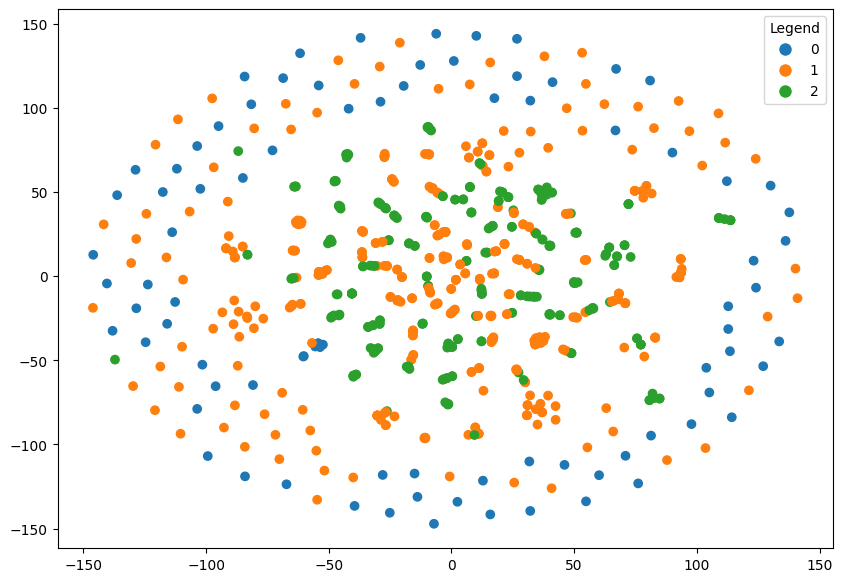

In [76]:
get_clustering_stats(3)

/home/technet/miniconda3/envs/technet/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,monofact_count,count,monofact_rate,generated_hallucinations_count,generated_facts_count,all_generations_count,hallucination_rate,expected_hallucination_count,more_hallucinations_than_expected,higher_hallucination_rate_than_expected,higher_monofact_rate_than_average
cluster,,,,,,,,,,,
2,235,287,0.818815,24,368,392,0.061224,19.73125,True,True,True
3,197,330,0.596970,29,402,431,0.067285,22.68750,True,True,True
0,26,91,0.285714,1,85,86,0.011628,6.25625,False,False,False
1,2,92,0.021739,1,90,91,0.010989,6.32500,False,False,False


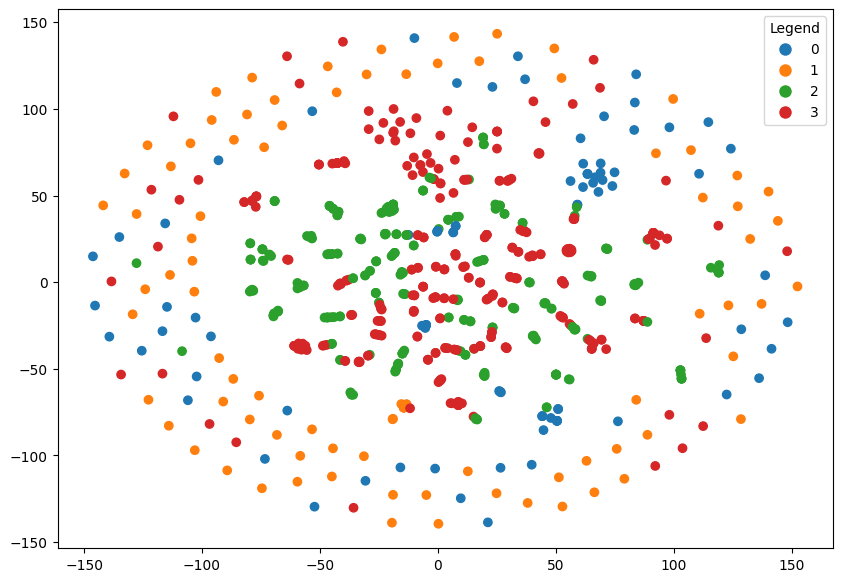

In [77]:
get_clustering_stats(4)

/home/technet/miniconda3/envs/technet/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,monofact_count,count,monofact_rate,generated_hallucinations_count,generated_facts_count,all_generations_count,hallucination_rate,expected_hallucination_count,more_hallucinations_than_expected,higher_hallucination_rate_than_expected,higher_monofact_rate_than_average
cluster,,,,,,,,,,,
0,75,84,0.892857,8,84,92,0.086957,5.77500,True,True,True
4,163,211,0.772512,17,290,307,0.055375,14.50625,True,True,True
1,194,322,0.602484,28,396,424,0.066038,22.13750,True,True,True
3,26,91,0.285714,1,85,86,0.011628,6.25625,False,False,False
2,2,92,0.021739,1,90,91,0.010989,6.32500,False,False,False


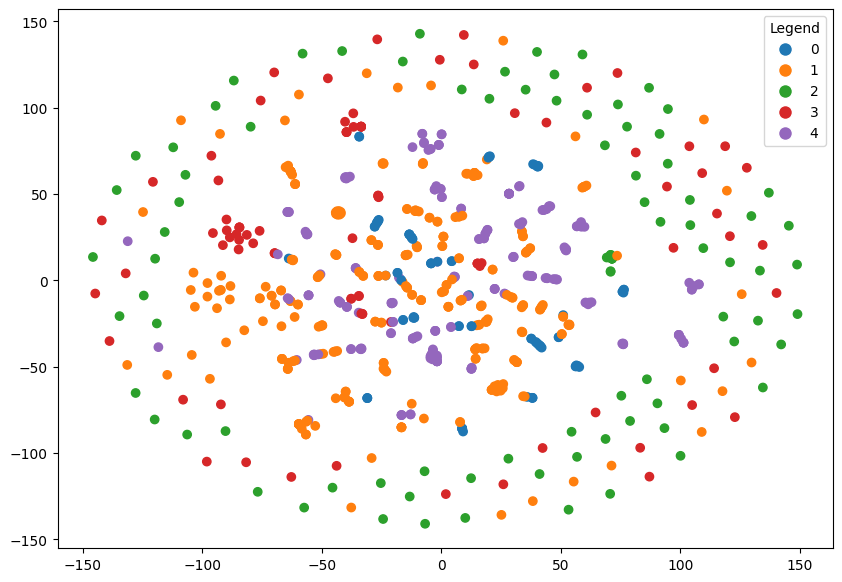

In [78]:
get_clustering_stats(5)

/home/technet/miniconda3/envs/technet/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,monofact_count,count,monofact_rate,generated_hallucinations_count,generated_facts_count,all_generations_count,hallucination_rate,expected_hallucination_count,more_hallucinations_than_expected,higher_hallucination_rate_than_expected,higher_monofact_rate_than_average
cluster,,,,,,,,,,,
2,220,268,0.820896,21,350,371,0.056604,18.42500,True,True,True
0,185,269,0.687732,25,302,327,0.076453,18.49375,True,True,True
4,20,38,0.526316,5,29,34,0.147059,2.61250,True,True,False
5,26,75,0.346667,3,112,115,0.026087,5.15625,False,False,False
3,7,58,0.120690,0,62,62,0.000000,3.98750,False,False,False
1,2,92,0.021739,1,90,91,0.010989,6.32500,False,False,False


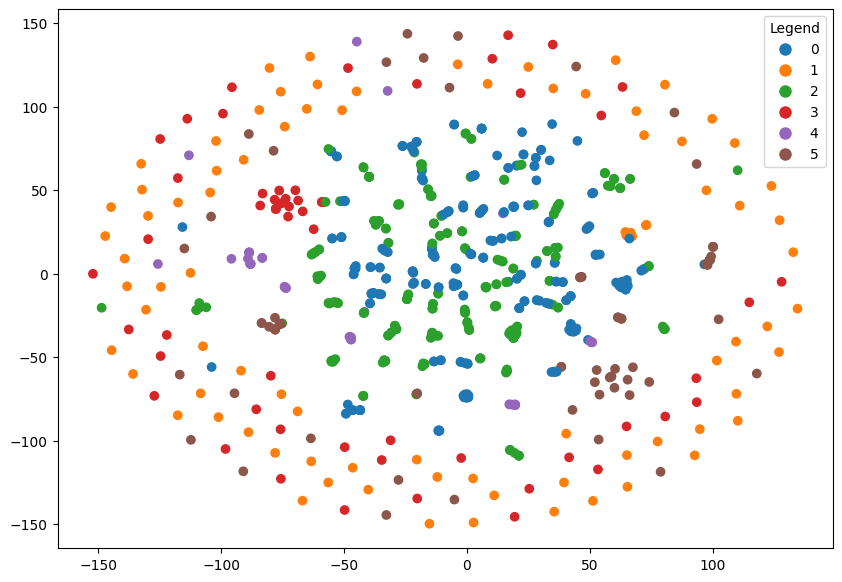

In [79]:
get_clustering_stats(6)

/home/technet/miniconda3/envs/technet/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,monofact_count,count,monofact_rate,generated_hallucinations_count,generated_facts_count,all_generations_count,hallucination_rate,expected_hallucination_count,more_hallucinations_than_expected,higher_hallucination_rate_than_expected,higher_monofact_rate_than_average
cluster,,,,,,,,,,,
2,88,102,0.862745,12,123,135,0.088889,7.01250,True,True,True
3,82,99,0.828283,6,137,143,0.041958,6.80625,False,False,True
6,73,94,0.776596,7,112,119,0.058824,6.46250,True,True,True
5,170,254,0.669291,24,291,315,0.076190,17.46250,True,True,True
0,26,75,0.346667,3,112,115,0.026087,5.15625,False,False,False
4,19,84,0.226190,2,80,82,0.024390,5.77500,False,False,False
1,2,92,0.021739,1,90,91,0.010989,6.32500,False,False,False


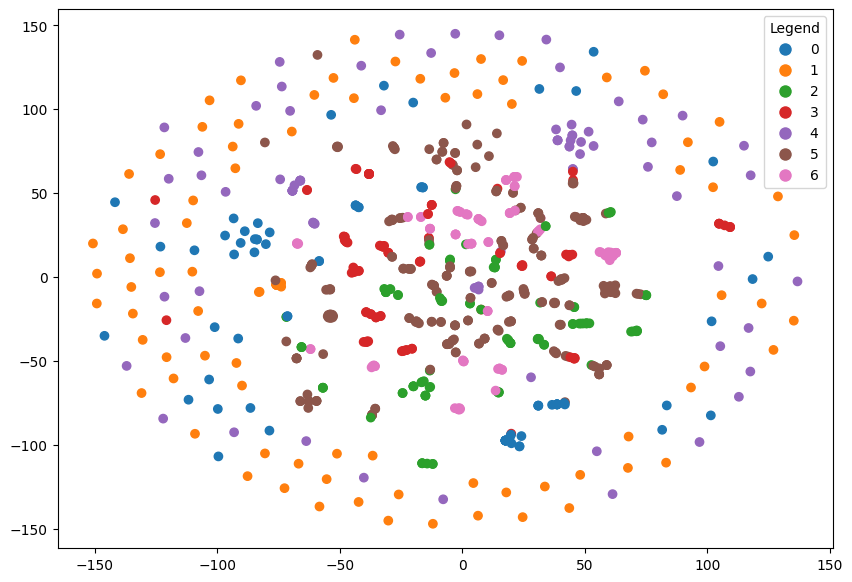

In [80]:
get_clustering_stats(7)

/home/technet/miniconda3/envs/technet/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,monofact_count,count,monofact_rate,generated_hallucinations_count,generated_facts_count,all_generations_count,hallucination_rate,expected_hallucination_count,more_hallucinations_than_expected,higher_hallucination_rate_than_expected,higher_monofact_rate_than_average
cluster,,,,,,,,,,,
0,108,114,0.947368,9,141,150,0.060000,7.83750,True,True,True
4,62,77,0.805195,10,89,99,0.101010,5.29375,True,True,True
6,96,129,0.744186,14,134,148,0.094595,8.86875,True,True,True
5,65,98,0.663265,6,139,145,0.041379,6.73750,False,False,True
7,45,83,0.542169,6,106,112,0.053571,5.70625,True,False,False
3,60,120,0.500000,8,162,170,0.047059,8.25000,False,False,False
1,21,86,0.244186,1,84,85,0.011765,5.91250,False,False,False
2,3,93,0.032258,1,90,91,0.010989,6.39375,False,False,False


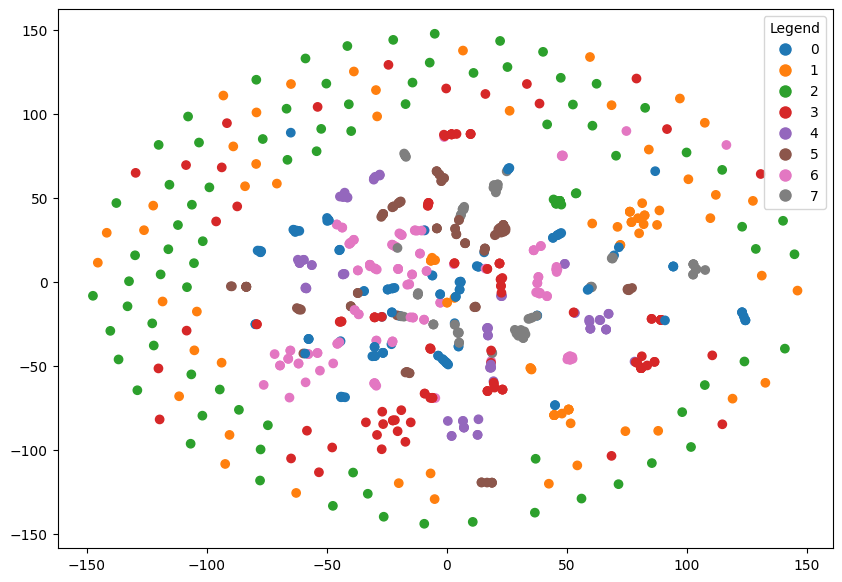

In [81]:
get_clustering_stats(8)